In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00270.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00793.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00064.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00106.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00418.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00249.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00634.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00259.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00061.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00262.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00222.xml
/kaggle/input/processed-uatd/processed_uatd/processed_test_2/annotations/00307.xml
/kag

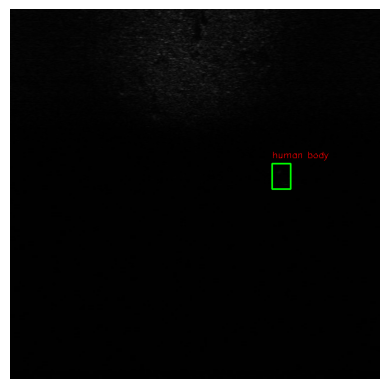

In [3]:
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# Load image
img = cv2.imread("/kaggle/input/processed-uatd/processed_uatd/processed_training/images/00001.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Load and parse XML
tree = ET.parse("/kaggle/input/processed-uatd/processed_uatd/processed_training/annotations/00001.xml")
root = tree.getroot()

# Draw bounding boxes
for obj in root.findall("object"):
    name = obj.find("name").text
    bbox = obj.find("bndbox")
    xmin, ymin, xmax, ymax = [int(bbox.find(tag).text) for tag in ["xmin", "ymin", "xmax", "ymax"]]
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
    cv2.putText(img, name, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)

plt.imshow(img)
plt.axis("off")
plt.show()


In [4]:
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
from tqdm import tqdm

# === Step 1: Filter valid images with proper bounding boxes ===

image_dir = '/kaggle/input/processed-uatd/processed_uatd/processed_training/images'
annotation_dir = '/kaggle/input/processed-uatd/processed_uatd/processed_training/annotations'
valid_images = []

image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]

for f in image_files:
    xml_path = os.path.join(annotation_dir, f.replace('.jpg', '.xml'))
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        has_valid_box = any(
            float(obj.find('bndbox/xmax').text) > float(obj.find('bndbox/xmin').text) and
            float(obj.find('bndbox/ymax').text) > float(obj.find('bndbox/ymin').text)
            for obj in root.findall('object')
        )
        if has_valid_box:
            valid_images.append(f)
    except Exception as e:
        print(f"Error parsing {f}: {e}")

with open('valid_images.txt', 'w') as f:
    f.writelines(f"{img}\n" for img in valid_images)

print(f"Total valid images: {len(valid_images)}")


# === Step 2: Dataset Class ===

class SonarDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, valid_list_path=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform

        with open(valid_list_path, 'r') as f:
            self.image_files = [line.strip() for line in f.readlines()]

        class_names = set()
        for f in self.image_files:
            try:
                tree = ET.parse(os.path.join(annotation_dir, f.replace('.jpg', '.xml')))
                for obj in tree.getroot().findall('object'):
                    class_names.add(obj.find('name').text.strip())
            except:
                continue
        self.classes = sorted(list(class_names))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        xml_path = os.path.join(self.annotation_dir, self.image_files[idx].replace('.jpg', '.xml'))

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = np.log10(img.astype(np.float32) + 10)
        img = ((img - img.min()) / (img.max() - img.min()) * 255).astype(np.uint8)
        img = np.stack([img] * 3, axis=-1)

        boxes, labels = [], []
        try:
            tree = ET.parse(xml_path)
            for obj in tree.getroot().findall('object'):
                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels.append(self.class_to_idx[obj.find('name').text.strip()])
        except Exception as e:
            print(f"Annotation error for {self.image_files[idx]}: {e}")

        if len(boxes) == 0:
            # Return a blank image with dummy target to avoid crashing
            dummy_target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'area': torch.zeros((0,), dtype=torch.float32),
                'iscrowd': torch.zeros((0,), dtype=torch.int64)
            }
            img = Image.fromarray(img)
            if self.transform:
                img = self.transform(img)
            return img, dummy_target

        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]),
            'iscrowd': torch.zeros((len(labels),), dtype=torch.int64)
        }

        return img, target


# === Step 3: Load Dataset ===

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = SonarDataset(image_dir, annotation_dir, transform=transform, valid_list_path='valid_images.txt')


# === Step 4: Load Model ===

model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = len(dataset.classes) + 1  # background class
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


# === Step 5: Training Setup ===

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === Step 6: Training ===

num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0.0
    for images, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")


Total valid images: 7595


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 188MB/s] 
Epoch 1/5: 100%|██████████| 1899/1899 [25:42<00:00,  1.23it/s]


Epoch 1: Loss = 0.1887


Epoch 2/5: 100%|██████████| 1899/1899 [25:16<00:00,  1.25it/s]


Epoch 2: Loss = 0.1405


Epoch 3/5: 100%|██████████| 1899/1899 [25:19<00:00,  1.25it/s]


Epoch 3: Loss = 0.1303


Epoch 4/5: 100%|██████████| 1899/1899 [25:16<00:00,  1.25it/s]


Epoch 4: Loss = 0.1186


Epoch 5/5: 100%|██████████| 1899/1899 [25:19<00:00,  1.25it/s]

Epoch 5: Loss = 0.1119


In [22]:
# Save the trained model after training
torch.save(model.state_dict(), 'fasterrcnn_model.pth')
print("Model saved successfully!")


Model saved successfully!


In [23]:
# model.load_state_dict(torch.load("fasterrcnn_model.pth"))
# model.eval()


/tmp/ipykernel_31/722359192.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("fasterrcnn_model.pth"))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [25]:
# Load the model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('fasterrcnn_model.pth'))
model.to(device)


/tmp/ipykernel_31/3210274093.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('fasterrcnn_model.pth'))


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [26]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Set model to evaluation mode
model.eval()

# Create an evaluation DataLoader (you can split your dataset into train/validation)
eval_loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

# Evaluate the model
def evaluate(model, data_loader, device):
    model.eval()
    results = []
    
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            predictions = model(images)
            results.extend(predictions)
    
    return results

# Run evaluation
results = evaluate(model, eval_loader, device)

# Process the evaluation results (you can visualize the predictions or calculate performance metrics here)
print("Evaluation complete!")


Evaluating: 100%|██████████| 1899/1899 [12:13<00:00,  2.59it/s]

Evaluation complete!


In [41]:
import os
import json
import xml.etree.ElementTree as ET
from PIL import Image

def get_valid_images(valid_images_file):
    with open(valid_images_file, 'r') as f:
        return [line.strip() for line in f.readlines() if line.strip().endswith('.jpg')]

def get_class_to_idx(annotation_dir, valid_images):
    classes = set()
    for image_name in valid_images:
        xml_path = os.path.join(annotation_dir, image_name.replace('.jpg', '.xml'))
        try:
            tree = ET.parse(xml_path)
            for obj in tree.getroot().findall('object'):
                class_name = obj.find('name').text.strip()
                classes.add(class_name)
        except:
            continue
    sorted_classes = sorted(classes)
    return {cls: idx + 1 for idx, cls in enumerate(sorted_classes)}

def convert_annotations_to_coco(image_dir, annotation_dir, valid_images, class_to_idx):
    coco_data = {
        'images': [],
        'annotations': [],
        'categories': [{'id': idx, 'name': name} for name, idx in class_to_idx.items()]
    }

    image_id = 1
    annotation_id = 1

    for image_name in valid_images:
        img_path = os.path.join(image_dir, image_name)
        xml_path = os.path.join(annotation_dir, image_name.replace('.jpg', '.xml'))

        if not os.path.exists(img_path) or not os.path.exists(xml_path):
            continue

        try:
            img = Image.open(img_path)
            width, height = img.size
        except Exception as e:
            print(f"Could not open image {image_name}: {e}")
            continue

        # Add image info
        image_info = {
            'id': image_id,
            'file_name': image_name,
            'width': width,
            'height': height
        }
        coco_data['images'].append(image_info)

        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            for obj in root.findall('object'):
                class_name = obj.find('name').text.strip()
                category_id = class_to_idx.get(class_name)

                if category_id is None:
                    continue

                bbox = obj.find('bndbox')
                xmin = float(bbox.find('xmin').text)
                ymin = float(bbox.find('ymin').text)
                xmax = float(bbox.find('xmax').text)
                ymax = float(bbox.find('ymax').text)
                w = xmax - xmin
                h = ymax - ymin

                annotation_info = {
                    'id': annotation_id,
                    'image_id': image_id,
                    'category_id': category_id,
                    'bbox': [xmin, ymin, w, h],
                    'area': w * h,
                    'iscrowd': 0,
                    'segmentation': [[]]  # Placeholder for segmentation
                }
                coco_data['annotations'].append(annotation_info)
                annotation_id += 1

        except Exception as e:
            print(f"Error parsing {xml_path}: {e}")
            continue

        image_id += 1

    return coco_data

# === USAGE ===
valid_images_file = 'valid_images.txt'
image_dir = '/kaggle/input/processed-uatd/processed_uatd/processed_training/images'
annotation_dir = '/kaggle/input/processed-uatd/processed_uatd/processed_training/annotations'

valid_images = get_valid_images(valid_images_file)
class_to_idx = get_class_to_idx(annotation_dir, valid_images)
coco_annotations = convert_annotations_to_coco(image_dir, annotation_dir, valid_images, class_to_idx)

# Save to JSON
with open('coco_annotations.json', 'w') as f:
    json.dump(coco_annotations, f, indent=4)

print("COCO annotations saved to coco_annotations.json")


COCO annotations saved to coco_annotations.json


In [42]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def convert_predictions_to_coco_format(predictions, image_ids, threshold=0.5):
    coco_format_predictions = []

    for i, prediction in enumerate(predictions):
        print(f"Prediction {i}: {prediction}")

        # If it's a list (some models wrap predictions in a list)
        if isinstance(prediction, list):
            prediction = prediction[0]

        image_id = image_ids[i]

        boxes = prediction['boxes'].detach().cpu().numpy()
        labels = prediction['labels'].detach().cpu().numpy()
        scores = prediction['scores'].detach().cpu().numpy()

        for box, label, score in zip(boxes, labels, scores):
            if score >= threshold:
                x_min, y_min, x_max, y_max = box
                width = x_max - x_min
                height = y_max - y_min

                coco_format_predictions.append({
                    'image_id': int(image_id),
                    'category_id': int(label),         # COCO requires integer category ID
                    'bbox': [float(x_min), float(y_min), float(width), float(height)],
                    'score': float(score)
                })

    return coco_format_predictions


In [43]:
import torch
from tqdm import tqdm

def evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Evaluating"):
            # Move images and targets to device
            images = [img.to(device) for img in images]

            # Run model
            outputs = model(images)  # List[Dict], one per image
            results.extend(outputs)

            # Get image_ids from targets
            for target in targets:
                image_ids.append(int(target["image_id"].item()))  # Ensure image_id is int

    return results, image_ids


In [45]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# Step 1: Evaluate model and get predictions
results, image_ids = evaluate(model, eval_loader, device)

# Step 2: Convert to COCO prediction format
coco_predictions = convert_predictions_to_coco_format(results, image_ids)

# Step 3: Save predictions to a file (optional)
with open('coco_predictions.json', 'w') as f:
    json.dump(coco_predictions, f)

# Step 4: Load ground truth COCO annotations (already in COCO format)
gt_coco = COCO('/kaggle/working/coco_annotations.json')

# Step 5: Load predictions into COCO format using loadRes()
pred_coco = gt_coco.loadRes(coco_predictions)

# Step 6: Run evaluation
coco_eval = COCOeval(gt_coco, pred_coco, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


Evaluating: 100%|██████████| 1899/1899 [12:15<00:00,  2.58it/s]


Prediction 0: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
Prediction 1: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
Prediction 2: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
Prediction 3: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
Prediction 4: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
Prediction 5: {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}
Prediction 6: {'boxes'

IndexError: list index out of range

In [46]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Path to your model
model_path = '/kaggle/working/fasterrcnn_model.pth'

# Load model
model = fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = 10  # change this to your number of classes (e.g., 2 if only background + 1 object)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torch.nn.Linear(in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# Image path (replace with your own test image)
image_path = '/kaggle/input/processed-uatd/processed_uatd/processed_test_1/images/00001.jpg'
image = Image.open(image_path).convert("RGB")
image_tensor = F.to_tensor(image).unsqueeze(0)  # Add batch dimension

# Run inference
with torch.no_grad():
    prediction = model(image_tensor)

# Draw results
image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# Set a threshold
threshold = 0.5
for box, label, score in zip(boxes, labels, scores):
    if score >= threshold:
        x1, y1, x2, y2 = box.int()
        cv2.rectangle(image_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        text = f"Class: {label.item()} | {score:.2f}"
        cv2.putText(image_cv, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show image using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Predictions")
plt.show()


/tmp/ipykernel_31/104501229.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "roi_heads.box_predictor.weight", "roi_heads.box_predictor.bias". 
	Unexpected key(s) in state_dict: "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 